# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [23]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [24]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [25]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
         # Перший шар, 128 нейронів
        self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
         # Другий шар, 256 нейронів
        self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
        # Вихідний шар
        self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)
    
    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        # Місце для вашого коду
        x = self.layer_1(x, activation=0)
        x = self.layer_2(x, activation=0)
        x = self.out_layer(x, activation=1)
        return x

In [26]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):    
    corr_predict = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    
    return tf.reduce_mean(tf.cast(corr_predict, tf.float32))

In [27]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [28]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        predict = neural_net(batch_x)
        
        loss = cross_entropy(predict, batch_y)
        loss_history.append(loss)
        
        current_accuracy = accuracy(predict, batch_y)
        accuracy_history.append(current_accuracy)
        
        print(f"Крок: {step}, Втрати: {loss:.4f}, Точність: {current_accuracy:.4f}")


Крок: 100, Втрати: 282.8838, Точність: 0.6914
Крок: 200, Втрати: 207.6931, Точність: 0.7617
Крок: 300, Втрати: 177.1191, Точність: 0.8203
Крок: 400, Втрати: 127.1196, Точність: 0.8320
Крок: 500, Втрати: 112.6810, Точність: 0.8594
Крок: 600, Втрати: 116.6828, Точність: 0.8438
Крок: 700, Втрати: 73.7447, Точність: 0.8828
Крок: 800, Втрати: 119.3578, Точність: 0.8789
Крок: 900, Втрати: 105.1705, Точність: 0.8789
Крок: 1000, Втрати: 92.4544, Точність: 0.9023
Крок: 1100, Втрати: 96.6580, Точність: 0.8984
Крок: 1200, Втрати: 84.8091, Точність: 0.9023
Крок: 1300, Втрати: 74.5165, Точність: 0.9062
Крок: 1400, Втрати: 80.4299, Точність: 0.9258
Крок: 1500, Втрати: 57.6137, Точність: 0.9180
Крок: 1600, Втрати: 127.3473, Точність: 0.8633
Крок: 1700, Втрати: 112.1258, Точність: 0.8828
Крок: 1800, Втрати: 75.5402, Точність: 0.9219
Крок: 1900, Втрати: 47.4028, Точність: 0.9375
Крок: 2000, Втрати: 60.8172, Точність: 0.9219
Крок: 2100, Втрати: 72.6814, Точність: 0.9102
Крок: 2200, Втрати: 71.6482, Точн

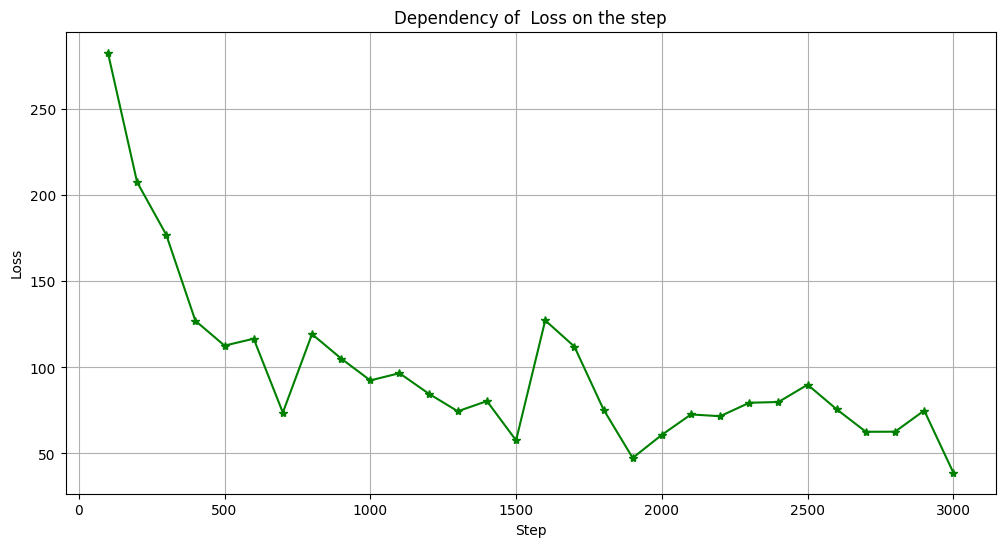

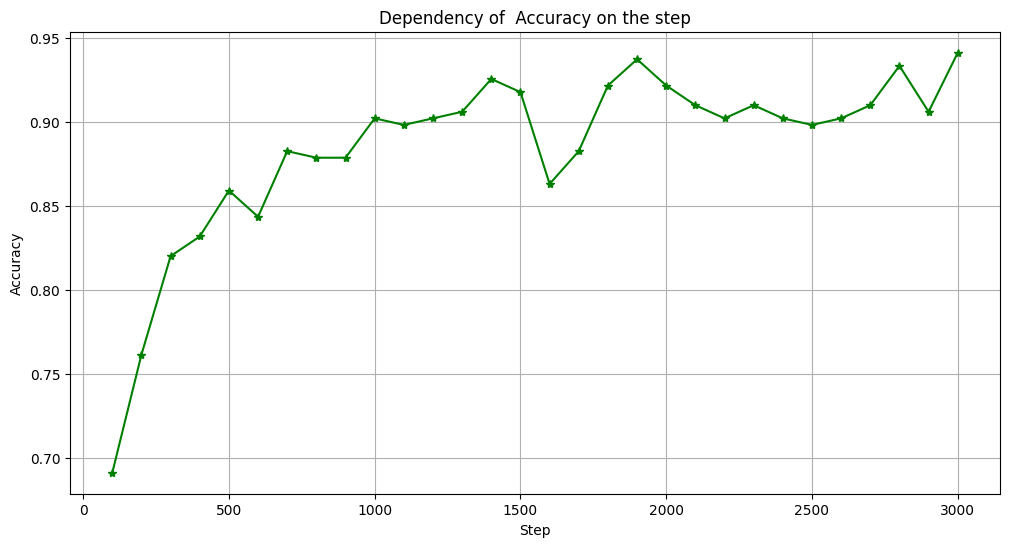

In [30]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt
def show_plt(history, name):
    plt.figure(figsize=(12, 6))
    plt.plot(range(100, 3001, 100), history, linestyle="-", marker="*", color="g")
    plt.title(f'Dependency of  {name} on the step')
    plt.xlabel('Step')
    plt.ylabel(f'{name}')
    plt.grid(True)
    plt.show()
    
# Виведіть графік функції втрат
show_plt(loss_history, "Loss")

# Виведіть графік точності
show_plt(accuracy_history, "Accuracy")


Accuracy of the trained neural network is 0.9217000007629395
Test digit is 4
The network has predicted the number 4
Image of the figure


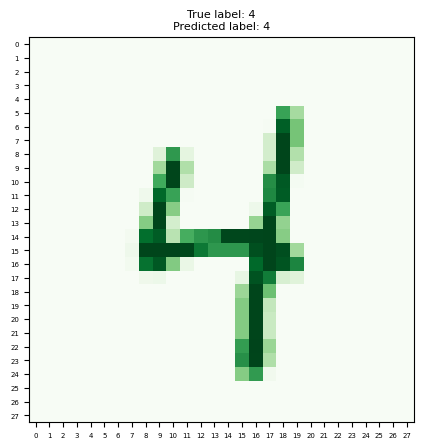

In [51]:
# Обчисліть точність навченої нейромережі
accuracy_neural_net = accuracy(neural_net(x_train), y_train)
print(f"Accuracy of the trained neural network is {accuracy_neural_net}")

# Тестування моделі на тестових даних
idx_of_some_digit = 19
test_image = x_test[idx_of_some_digit].reshape(1, -1)
test_digit = y_test[idx_of_some_digit]

print(f'Test digit is {test_digit}')
p_pred = neural_net(test_image)
y_pred = p_pred[0].numpy()
predicted_digit = y_pred.argmax()

print(f'The network has predicted the number {predicted_digit}')

print(f'Image of the figure')

plt.figure(figsize=(5, 5))
plt.xticks(range(0, 28, 1), fontsize=5)
plt.yticks(range(0, 28, 1), fontsize=5)
plt.imshow(test_image[0].reshape((28, 28)), cmap='Greens', interpolation='nearest')  
plt.title(f"True label: {test_digit}\nPredicted label: {predicted_digit}", fontsize=8)
plt.grid(False)  
plt.show()

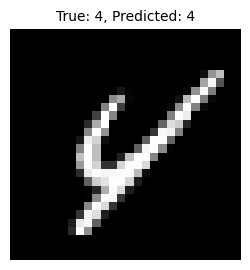

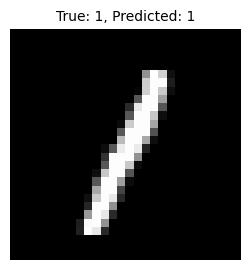

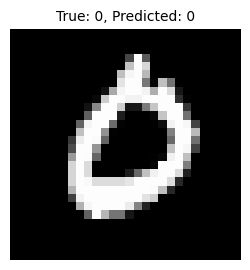

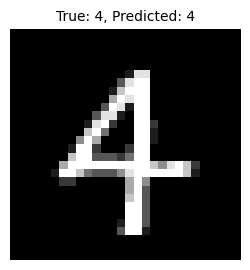

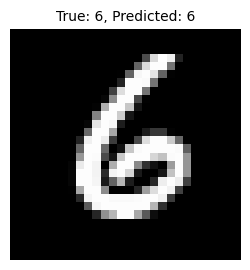

Accuracy of the trained neural network 100.0%


In [53]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?


images_number = 5
random_indices = random.sample(range(len(x_test)), images_number)

test_images = x_test[random_indices]
test_labels = y_test[random_indices]

predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1)

correct_predictions = 0

for i in range(len(test_images)):
    image = test_images[i].reshape((28, 28))
    true_label = test_labels[i]
    predicted_label = predicted_labels[i]
    
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f'True: {true_label}, Predicted: {predicted_label}', fontsize=10)
    plt.show()
    
    if predicted_label == true_label:
        correct_predictions += 1

accuracy = (correct_predictions / images_number) * 100
print(f'Accuracy of the trained neural network {accuracy}%')



**Висновки:**

 Так як точність передбачення сягає 100%, можна зробити висновки що модель ідеально відповідає навчальним даним.
 Але 100% свідчать ще й про те, що може бути оверфітінг, коли модель дуже гарно вивчила існуючі данні і може зробити помилки на нових, невідомих данних. 